In [1]:
import pandas as pd
test_csv = pd.read_csv('../raw_data/Amharic_Data/test/all_test.csv')
train_csv = pd.read_csv('../raw_data/Amharic_Data/train/all_train.csv')

In [2]:
all_text = ''.join(test_csv['line_text'].tolist() + train_csv['line_text'].tolist())

In [3]:
vocab = set(all_text)


In [4]:
CHARS = ''.join(sorted(vocab))

In [5]:
import os
import glob

import torch
from torch.utils.data import Dataset
from scipy import signal
from scipy.io import wavfile
import cv2
from PIL import Image
import numpy as np


class MyDataset(Dataset):
    CHARS = ''.join(sorted(vocab))
    CHAR2LABEL = {char: i + 1 for i, char in enumerate(CHARS)}
    LABEL2CHAR = {label: char for char, label in CHAR2LABEL.items()}

    def __init__(self, root_dir=None, mode=None, df=None, img_height=80, img_width=364):
       

        self.paths = df['image_filename'].tolist()
        self.texts = df['line_text'].tolist()
        self.img_height = img_height
        self.img_width = img_width
        self.root_dir = root_dir

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = os.path.join(self.root_dir, self.paths[index])

        try:
            image = Image.open(path).convert('L')  # grey-scale
        except IOError:
            print('Corrupted image for %d' % index)
            return self[index + 1]

        image = image.resize((self.img_width, self.img_height), resample=Image.BILINEAR)
        image = np.array(image)
        image = image.reshape((1, self.img_height, self.img_width))
        image = (image / 127.5) - 1.0

        image = torch.FloatTensor(image)
        if self.texts:
            text = self.texts[index]
            target = [self.CHAR2LABEL[c] for c in text]
            target_length = [len(target)]

            target = torch.LongTensor(target)
            target_length = torch.LongTensor(target_length)
            return image, target, target_length
        else:
            return image


def my_collate_fn(batch):
    images, targets, target_lengths = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.cat(targets, 0)
    target_lengths = torch.cat(target_lengths, 0)
    return images, targets, target_lengths

In [6]:
from __future__ import annotations
from typing import List, Tuple, Sequence
class LabelConverter:
    """String ⇄ index-tensor converter for CTC.

    ● blank index = 0
    ● char indices start at 1 → len(charset) + 1 classes in the model.
    """

    def __init__(self, charset: str):
        self.charset   = charset
        self.blank     = 0
        self.char2idx  = {c: i + 1 for i, c in enumerate(charset)}  # 1‑based
        self.idx2char  = {i + 1: c for i, c in enumerate(charset)}

    # --------------------------- Encode ------------------------------------ #
    def encode(self, texts: List[str]) -> Tuple[torch.Tensor, torch.Tensor]:
        lengths = torch.tensor([len(t) for t in texts], dtype=torch.long)
        flat    = torch.tensor([self.char2idx[c] for t in texts for c in t], dtype=torch.long)
        return flat, lengths

    # --------------------------- Decode log‑probs --------------------------- #
    @torch.no_grad()
    def decode(self, log_probs: torch.Tensor, raw: bool = False) -> List[str]:
        """Greedy decode from model output (T, B, C)."""
        best = log_probs.argmax(2).permute(1, 0)  # (B,T)
        return self.decode_indices(best, remove_repeats=True, raw=raw)

    # --------------------------- Decode raw indices ------------------------ #
    def decode_indices(
        self,
        sequences: Sequence[Sequence[int]] | torch.Tensor,
        *,
        remove_repeats: bool = False,
        raw: bool = True,
    ) -> List[str]:
        """Convert index sequences → strings.

        Parameters
        ----------
        sequences : (B,T) tensor or list of lists containing *model indices* (0 = blank).
        remove_repeats : drop consecutive duplicate indices (CTC best‑path post‑process).
        raw   : if True, return the indices as space‑separated strings instead of chars.
        """
        if isinstance(sequences, torch.Tensor):
            sequences = sequences.tolist()

        out: List[str] = []
        for seq in sequences:
            chars: List[str] = []
            prev: int | None = None
            for idx in seq:
                if isinstance(idx, torch.Tensor):
                    idx = idx.item()
                if idx != self.blank:
                    if raw:
                        chars.append(str(idx))
                    else:
                        
                        chars.append(self.idx2char.get(idx, ""))
               
            out.append(" ".join(chars) if raw else "".join(chars))
        return out

In [8]:

data_type = "hdd"  # or "real"
# Assuming your DataFrame is named `df`
typed_df = train_csv[train_csv['type'] != data_type]

In [9]:
len(typed_df)

112716

In [8]:
converter = LabelConverter(MyDataset.CHARS)

In [9]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(typed_df, test_size=0.2, random_state=42, shuffle=True)


In [10]:
img_width = 1000
img_height = 100
data_dir =  '/home/admin/Gabby/Amharic OCR/HandWritten_Amharic_English_OCR/raw_data/Amharic_Data/train'

In [11]:
train_dataset =MyDataset(root_dir=data_dir, mode='train',
                                    df=train_df, img_height=img_height, img_width=img_width)
valid_dataset = MyDataset(root_dir=data_dir, mode='valid',
                                    df=val_df, img_height=img_height, img_width=img_width)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    collate_fn=my_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    collate_fn=my_collate_fn,
)

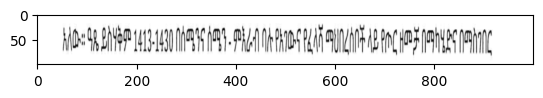

In [12]:
import matplotlib.pyplot as plt
image = train_dataset.__getitem__(0)[0]
image = image.squeeze(0).numpy()


plt.imshow(image, cmap='gray')


Image 0 shape: torch.Size([1, 100, 1000])
Target indices: [137, 241, 70, 5, 5, 255, 95, 75, 113, 5, 5, 235, 87, 158, 5, 5, 280, 245, 5, 229, 115, 296, 5, 5, 227, 183, 5, 90, 237, 204, 77, 5, 5, 255, 71, 180, 229, 5, 5, 255, 210, 78, 193, 5, 5, 131, 263, 115, 5, 5, 89, 207, 200, 77, 5, 5, 141, 153, 209, 107, 115, 155, 258, 185, 185, 5, 5, 299, 92, 108, 5, 5, 137, 137, 107, 74, 185, 5, 5, 350, 5, 137, 65, 92, 138, 107, 284, 5, 5, 350, 5, 137, 207, 115, 77, 5, 5, 350, 5, 4, 3]
Decoded text: ['በዚህ  የሠላሳ  ዓመት  ጉዞ ውስጥ  ዋና ማዕከል  የሆነው  የኮሎኝ  ቅዱስ  ሚካኤል  ቤተክርስቲያንን  ጨምሮ  በበርሊን  ፣ በሀምቡርግ  ፣ በካስል  ፣ \r\n']


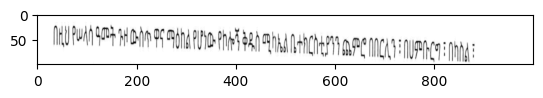

In [13]:
for images, targets, target_lengths in train_loader:
    
    batch_size = images.size(0)
    
    # Split targets back using target_lengths
    split_targets = torch.split(targets, target_lengths.tolist())

    for i in range(batch_size):
        img = images[i]
        target_tensor = split_targets[i]  # 1D tensor of label indices for this sample
        plt.imshow(img.squeeze(0).numpy(), cmap='gray')
        print(f"Image {i} shape: {img.shape}")
        print(f"Target indices: {target_tensor.tolist()}")
        
        # Optionally decode target_tensor using your label converter
        decoded_text = converter.decode_indices([target_tensor], raw=False)
        print(f"Decoded text: {decoded_text}")
        
        break  # remove or modify to check more
    break

### Modeling

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CRNN(nn.Module):
    def __init__(self, num_classes: int, hidden_size: int = 256):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True),
            nn.AdaptiveAvgPool2d((1, None)),
        )
        self.map_to_seq = nn.Linear(512, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, bidirectional=True, batch_first=True)
        self.classifier = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass.
        Accepts (B,1,80,W) and outputs CTC‑ready log‑probs (T, B, C).
        We **average over the height dimension** instead of squeezing so we
        never hit a dim‑mismatch even if `AdaptiveAvgPool2d` leaves H>1 on
        some PyTorch builds.
        """
        feats = self.cnn(x)              # (B, 512, H', W')
        feats = feats.mean(2)            # collapse H' → (B, 512, W')
        feats = feats.permute(0, 2, 1)   # (B, W', 512)
        seq, _ = self.rnn(self.map_to_seq(feats))
        logits = self.classifier(seq)    # (B, W', C)
        log_probs = F.log_softmax(logits, dim=-1)  # (B,W',C)
        return log_probs.permute(1, 0, 2)  

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
model = CRNN(len(MyDataset.CHARS)+1).to(device)


In [17]:
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [18]:
def _levenshtein(a: str, b: str) -> int:
    if a == b:
        return 0
    if len(a) < len(b):
        a, b = b, a
    prev = list(range(len(b) + 1))
    for i, ca in enumerate(a, 1):
        cur = [i]
        for j, cb in enumerate(b, 1):
            cur.append(min(prev[j]+1,      # deletion
                            cur[-1]+1,     # insertion
                            prev[j-1] + (ca != cb)))  # substitution
        prev = cur
    return prev[-1]


def _update_char_counts(pred: str, gt: str):
    dist = _levenshtein(pred, gt)
    tp = len(gt) - dist  # correct chars = ground truth − edit distance
    return tp, len(pred), len(gt)

def _split_targets(targets: torch.Tensor, lengths: torch.Tensor) -> List[List[int]]:
    out, ptr = [], 0
    for l in lengths:
        out.append(targets[ptr:ptr+l].tolist())
        ptr += l
    return out

In [19]:
import json
from tqdm.auto import tqdm
from collections import Counter

def run_epoch(model, loader, crit, opt, device, conv, *, train=True,
              save_samples: bool=False, sample_count: int=20,
              log_dir: str="logs", epoch_idx: int=0,
              best_cer: float=float("inf")) -> Tuple[dict, float]:
    os.makedirs(log_dir, exist_ok=True)
    model.train() if train else model.eval()
    name = "train" if train else "val"
    bar = tqdm(loader, desc=f"[{name}]", leave=False)

    tot_loss = tot_ed = tot_wed = 0
    tp_char = pred_tot = gt_tot = 0
    tp_word = 0
    samples = []
    tp_word = fp_word = fn_word = 0  
    for imgs, tgt, tlen in bar:
        imgs, tgt, tlen = imgs.to(device), tgt.to(device), tlen.to(device)
        with torch.set_grad_enabled(train):
            logp = model(imgs)
            in_len = torch.full((imgs.size(0),), logp.size(0), dtype=torch.long, device=device)
            loss = crit(logp, tgt, in_len, tlen)
            if train:
                opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
        # metrics
        gts  = conv.decode_indices(_split_targets(tgt.cpu(), tlen.cpu()), remove_repeats=False)
        gts = [list(map(int, g.split())) for g in gts]
        gts = conv.decode_indices(gts, raw=False)
        
     
        preds= conv.decode(logp.detach().cpu())
        for p, g in zip(preds, gts):
            if save_samples and len(samples) < sample_count:
                samples.append({"gt": g, "pred": p})

            # Levenshtein for CER and WER
            ed = _levenshtein(p, g)
            tot_ed += ed
            tot_wed += _levenshtein(p.split(), g.split())

            # Char-level stats
            tp_char += len(g) - ed
            pred_tot += len(p)
            gt_tot += len(g)

            # Word-level stats
            p_words = p.split()
            g_words = g.split()
            p_counter = Counter(p_words)
            g_counter = Counter(g_words)

            for word in p_counter:
                tp_word += min(p_counter[word], g_counter.get(word, 0))
                fp_word += max(0, p_counter[word] - g_counter.get(word, 0))
            for word in g_counter:
                fn_word += max(0, g_counter[word] - p_counter.get(word, 0))

            tot_loss += loss.item()
            bar.set_postfix(loss=loss.item())

    cer = tot_ed/max(1,gt_tot)
    wer = tot_wed/max(1,gt_tot)
    prec = tp_char/pred_tot if pred_tot else 0; rec = tp_char/gt_tot if gt_tot else 0
    f1c = 2*prec*rec/(prec+rec) if prec+rec else 0
    word_prec = tp_word / (tp_word + fp_word + 1e-8)
    word_rec = tp_word / (tp_word + fn_word + 1e-8)
    f1w = 2 * word_prec * word_rec / (word_prec + word_rec + 1e-8)
    stats = dict(loss=tot_loss/len(loader), CER=cer, WER=wer, F1_char=f1c, F1_word=f1w)

    # ── save sample predictions
    if save_samples:
        samp_path = os.path.join(log_dir, f"samples_epoch{epoch_idx}.json")
        with open(samp_path, "w", encoding="utf8") as f:
            json.dump(samples, f, ensure_ascii=False, indent=2)

    # ── checkpoint best CER
    if not train and cer < best_cer:
        ckpt = {
            "epoch": epoch_idx,
            "model": model.state_dict(),
            "optimizer": opt.state_dict(),
            "CER": cer,
        }
        torch.save(ckpt, os.path.join(log_dir, "best_cer.pt"))
        best_cer = cer

    return stats, best_cer

In [20]:
import wandb

# This prompts you to enter your API key the first time
wandb.login(key="7a2297338ed4c184a8cf1c11b29bd7f0f010f9e3")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/admin/.netrc
wandb: Currently logged in as: gzenchaa to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
model_name = "crnn_typed"
wandb.init(project="Amharic OCR", name=model_name)

In [ ]:
 # ── training loop ────────────────────────────────
wandb.watch(model, log="all")
epochs = 50
LOG_DIR = f"{model_name}_logs"
best_cer = float("inf")
for epoch in range(1, epochs+1):
    print(f"\nEpoch {epoch}/{epochs}")
    train_stats , _ = run_epoch(model, train_loader, criterion, optimizer, device, converter, train=True,
                           epoch_idx=epoch)
    val_stats, best_cer = run_epoch(model, valid_loader, criterion, optimizer, device, converter,
                                        train=False, save_samples=True, sample_count=10,
                                        log_dir=LOG_DIR, epoch_idx=epoch, best_cer=best_cer)
    print(f"train: {train_stats}\nval  : {val_stats}")
    ## add T to train starts keys
    train_stats = {f"train_{k}": v for k, v in train_stats.items()}
    val_stats   = {f"val_{k}": v for k, v in val_stats.items()}
    wandb.log({"epoch": epoch, **train_stats, **val_stats})


Epoch 1/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 273.95609938122624, 'CER': 1.005873991225904, 'WER': 0.17611977420358688, 'F1_char': -0.01163719351726276, 'F1_word': 0.0}
val  : {'loss': 248.70973867765613, 'CER': 1.0, 'WER': 0.17576130333414386, 'F1_char': 0, 'F1_word': 0.0}

Epoch 2/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/py

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/py

train: {'loss': 191.62042347137614, 'CER': 0.7089381416124558, 'WER': 0.17563840681078335, 'F1_char': 0.37080354273169963, 'F1_word': 0.006240550196174407}
val  : {'loss': 129.8602733746381, 'CER': 0.5705376682448186, 'WER': 0.17196849417609505, 'F1_char': 0.4117267268125175, 'F1_word': 0.02726809599558937}

Epoch 3/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 72.5320204644865, 'CER': 0.3052018024204033, 'WER': 0.12484611416320913, 'F1_char': 0.6746215177305825, 'F1_word': 0.30453355886027134}
val  : {'loss': 49.73885400866119, 'CER': 0.21295276510329506, 'WER': 0.09217885085749432, 'F1_char': 0.7669456237041855, 'F1_word': 0.49130455277902263}

Epoch 4/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 36.14057366703753, 'CER': 0.16627762581747668, 'WER': 0.06556116787226687, 'F1_char': 0.8007726674600988, 'F1_word': 0.6400755990481455}
val  : {'loss': 32.00975097233141, 'CER': 0.14839634021331274, 'WER': 0.05423883970077096, 'F1_char': 0.8152274498482983, 'F1_word': 0.7009613827779213}

Epoch 5/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 27.643582553625954, 'CER': 0.13667977882090573, 'WER': 0.04822837163942786, 'F1_char': 0.8285347840809872, 'F1_word': 0.7357848354450389}
val  : {'loss': 29.44407376017369, 'CER': 0.15563629081858882, 'WER': 0.0567181115576979, 'F1_char': 0.8020497793860399, 'F1_word': 0.6854002748493986}

Epoch 6/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 24.158858689230957, 'CER': 0.12815142425841752, 'WER': 0.044018638259842, 'F1_char': 0.8364575171793719, 'F1_word': 0.7588034027926647}
val  : {'loss': 24.19657893164057, 'CER': 0.1309913749946362, 'WER': 0.04774267065257296, 'F1_char': 0.8300005123038303, 'F1_word': 0.7361579412633926}

Epoch 7/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 22.520756046702004, 'CER': 0.1265198922546261, 'WER': 0.044668394987828965, 'F1_char': 0.8378496769161797, 'F1_word': 0.7550273181453807}
val  : {'loss': 22.835011246338695, 'CER': 0.13544691259136354, 'WER': 0.05160222943753904, 'F1_char': 0.8235875215457041, 'F1_word': 0.7139118978361365}

Epoch 8/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/py

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
AssertionError: can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>Traceback (most recent call last):

  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py"

train: {'loss': 21.09575112243564, 'CER': 0.12220186608704241, 'WER': 0.04206401293801309, 'F1_char': 0.8422646124263251, 'F1_word': 0.7693897484415675}
val  : {'loss': 22.02423915896617, 'CER': 0.11855448915080172, 'WER': 0.04212855024578166, 'F1_char': 0.8464942605048558, 'F1_word': 0.7676500099402798}

Epoch 9/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 20.216651975260085, 'CER': 0.11946479562116327, 'WER': 0.0405889699630317, 'F1_char': 0.8455027355873171, 'F1_word': 0.7775246594366431}
val  : {'loss': 21.393771444407985, 'CER': 0.11185568730660488, 'WER': 0.04030008725129804, 'F1_char': 0.8560750197613926, 'F1_word': 0.7782407388875217}

Epoch 10/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 19.786382087290924, 'CER': 0.11777316707018622, 'WER': 0.03874085238324461, 'F1_char': 0.84771407596801, 'F1_word': 0.7879884102228117}
val  : {'loss': 21.551554503575176, 'CER': 0.1161824934799918, 'WER': 0.03930599459328022, 'F1_char': 0.8499494489824458, 'F1_word': 0.7838401635296961}

Epoch 11/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 18.994261836931376, 'CER': 0.11425781656748753, 'WER': 0.037086114782025066, 'F1_char': 0.8520679305697582, 'F1_word': 0.797098720613193}
val  : {'loss': 23.951625562049973, 'CER': 0.12063564716147211, 'WER': 0.053840725854514423, 'F1_char': 0.8511668314587038, 'F1_word': 0.7033965194865596}

Epoch 12/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 18.79892102636901, 'CER': 0.11660217692304488, 'WER': 0.039230549990509504, 'F1_char': 0.848940942366165, 'F1_word': 0.7849339069039828}
val  : {'loss': 21.020236793118464, 'CER': 0.10450846051521176, 'WER': 0.03271208501995337, 'F1_char': 0.8663241090311138, 'F1_word': 0.821368375993712}

Epoch 13/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 18.254411528967452, 'CER': 0.11324034037256289, 'WER': 0.036636878216429684, 'F1_char': 0.8534277518033452, 'F1_word': 0.7995963739229871}
val  : {'loss': 21.083553511911713, 'CER': 0.08989744396607212, 'WER': 0.028199333457296926, 'F1_char': 0.8893620540441061, 'F1_word': 0.848052685308297}

Epoch 14/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/py

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>: 
can only test a child process
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in: self._shutdown_workers()<function _Multi

train: {'loss': 17.950269292257858, 'CER': 0.11331471728739656, 'WER': 0.03656726142414536, 'F1_char': 0.8532457445471486, 'F1_word': 0.7999018047479188}
val  : {'loss': 20.833413229022227, 'CER': 0.1086564730450703, 'WER': 0.038714783612013026, 'F1_char': 0.8596584808444402, 'F1_word': 0.7871062380352718}

Epoch 15/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 17.36833166959447, 'CER': 0.11192000138043554, 'WER': 0.03508091315810925, 'F1_char': 0.8547716392754445, 'F1_word': 0.8080705095892493}
val  : {'loss': 20.637005549081614, 'CER': 0.10943601333085407, 'WER': 0.035792103519135685, 'F1_char': 0.8592256959019268, 'F1_word': 0.8036825605658822}

Epoch 16/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 16.96505041181829, 'CER': 0.11212647169601381, 'WER': 0.035254657631160716, 'F1_char': 0.8545095385908706, 'F1_word': 0.8069321963242806}
val  : {'loss': 23.265044886461446, 'CER': 0.14347593914341158, 'WER': 0.04269353815933136, 'F1_char': 0.8127265550512517, 'F1_word': 0.7645393583702776}

Epoch 17/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 16.970465465107424, 'CER': 0.11368838690752094, 'WER': 0.03631914003626023, 'F1_char': 0.8527086918341389, 'F1_word': 0.8009526919380934}
val  : {'loss': 29.23438735411201, 'CER': 0.17740382093935797, 'WER': 0.0713481994288139, 'F1_char': 0.7767305649096902, 'F1_word': 0.606666706806497}

Epoch 18/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 16.812948817963914, 'CER': 0.1175851422294867, 'WER': 0.03745442926428141, 'F1_char': 0.8472277367433926, 'F1_word': 0.7945050077540377}
val  : {'loss': 20.772614685582443, 'CER': 0.1320689046863006, 'WER': 0.04105817229985839, 'F1_char': 0.8274227326599464, 'F1_word': 0.7736057939523486}

Epoch 19/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 16.285295103872162, 'CER': 0.11518663547993042, 'WER': 0.036254283366525274, 'F1_char': 0.8503360359932776, 'F1_word': 0.8012304121025914}
val  : {'loss': 21.375437793387494, 'CER': 0.14784327187599827, 'WER': 0.04820991804099381, 'F1_char': 0.8059572942583652, 'F1_word': 0.7334129119661366}

Epoch 20/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/py

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>AssertionError
: can only test a child processTraceback (most recent call last):

  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Exception ignored in: <function _Multi

train: {'loss': 15.931801384029864, 'CER': 0.12079227479711466, 'WER': 0.038257104929166404, 'F1_char': 0.8424976010044138, 'F1_word': 0.7896327015359185}
val  : {'loss': 20.74256471135247, 'CER': 0.1240255746427703, 'WER': 0.035298633062997346, 'F1_char': 0.837523205842231, 'F1_word': 0.8059818972339445}

Epoch 21/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 15.093702956397763, 'CER': 0.1156828782557007, 'WER': 0.03402059586024042, 'F1_char': 0.8488482902767136, 'F1_word': 0.8133726184261174}
val  : {'loss': 20.654231826604253, 'CER': 0.10902359599311526, 'WER': 0.035100768097492595, 'F1_char': 0.8601498464367455, 'F1_word': 0.80792154070715}

Epoch 22/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 14.706075313676719, 'CER': 0.11823549397279233, 'WER': 0.03475067965624775, 'F1_char': 0.8453363490254856, 'F1_word': 0.8091177879334677}
val  : {'loss': 22.210472824707836, 'CER': 0.13773070339803278, 'WER': 0.03700551637988166, 'F1_char': 0.8213848974980555, 'F1_word': 0.7970472136945114}

Epoch 23/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 15.458639062861531, 'CER': 0.12278438608401973, 'WER': 0.038546877389358386, 'F1_char': 0.840191293212442, 'F1_word': 0.7879996631436532}
val  : {'loss': 21.018636371048405, 'CER': 0.11558651466823051, 'WER': 0.03809973347827538, 'F1_char': 0.8534584792698288, 'F1_word': 0.7913129779142898}

Epoch 24/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 16.181126057041073, 'CER': 0.1325902385356911, 'WER': 0.043924030824173566, 'F1_char': 0.8271467292164202, 'F1_word': 0.7577689746015044}
val  : {'loss': 22.04279170909398, 'CER': 0.11039434726016621, 'WER': 0.03731065753150344, 'F1_char': 0.8660245996750987, 'F1_word': 0.8009534457798638}

Epoch 25/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 14.268163596952725, 'CER': 0.12176393481250175, 'WER': 0.03727949476059261, 'F1_char': 0.8402753345470735, 'F1_word': 0.794352505982636}
val  : {'loss': 20.639818954215922, 'CER': 0.1234438993224913, 'WER': 0.03070244446669432, 'F1_char': 0.8385342253166201, 'F1_word': 0.8324257476581324}

Epoch 26/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/py

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: AssertionError: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>can only test a child process

Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     self._shutdown_workers()<function _Multi

train: {'loss': 13.523989492742299, 'CER': 0.11895367746242627, 'WER': 0.03376830936512461, 'F1_char': 0.8437177525733838, 'F1_word': 0.8139093875644988}
val  : {'loss': 21.195228410019002, 'CER': 0.13197116416117174, 'WER': 0.03670991088924806, 'F1_char': 0.8264856558539869, 'F1_word': 0.7980023427840872}

Epoch 27/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 13.140551252456323, 'CER': 0.11707045397883768, 'WER': 0.03318638438346595, 'F1_char': 0.8462447201557812, 'F1_word': 0.8170024669785978}
val  : {'loss': 21.300744208231777, 'CER': 0.13748992795808124, 'WER': 0.039456181253844064, 'F1_char': 0.8191040667229635, 'F1_word': 0.7824824007169356}

Epoch 28/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 12.822637211279513, 'CER': 0.11664085291875839, 'WER': 0.03347734687429528, 'F1_char': 0.8467991756735868, 'F1_word': 0.8153596851245799}
val  : {'loss': 20.830144603487472, 'CER': 0.10524747424179576, 'WER': 0.03096705905911633, 'F1_char': 0.8652739130735484, 'F1_word': 0.8315840941896474}

Epoch 29/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 12.618046184000807, 'CER': 0.11694193067000509, 'WER': 0.03373558352259779, 'F1_char': 0.8464873830520346, 'F1_word': 0.8138031410065362}
val  : {'loss': 21.465633250248263, 'CER': 0.13301770295462456, 'WER': 0.03963020706687836, 'F1_char': 0.825250374128782, 'F1_word': 0.7815249216861159}

Epoch 30/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 12.632074469508225, 'CER': 0.11897390798326103, 'WER': 0.03452695389642806, 'F1_char': 0.8438570545206893, 'F1_word': 0.809406484651542}
val  : {'loss': 21.095747569916952, 'CER': 0.1347460415087323, 'WER': 0.039172495339445695, 'F1_char': 0.8233165851943427, 'F1_word': 0.7844164964528756}

Epoch 31/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 12.285669985190829, 'CER': 0.12046442135652782, 'WER': 0.034515648605373345, 'F1_char': 0.8417666717064253, 'F1_word': 0.8092667181160076}
val  : {'loss': 21.28766160195982, 'CER': 0.12352018461039672, 'WER': 0.03569674690925388, 'F1_char': 0.8391511350305155, 'F1_word': 0.8043436898553303}

Epoch 32/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>    
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/py

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>
Traceback (most recent call last):
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3cbfe270d0>: 
can only test a child process
Traceback (most recent call last):
Exception ignored in:   File "/home/admin/anaconda3/envs/pytorch-idl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__d

train: {'loss': 11.965872486344011, 'CER': 0.12029841208261907, 'WER': 0.0352802432898635, 'F1_char': 0.8419727803601266, 'F1_word': 0.8048422770837619}
val  : {'loss': 21.95712490862524, 'CER': 0.12704599526077648, 'WER': 0.039615903575396086, 'F1_char': 0.8340631495031745, 'F1_word': 0.7815898395454152}

Epoch 33/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 11.703597062635252, 'CER': 0.12116415937128301, 'WER': 0.03512553930700946, 'F1_char': 0.840832670827573, 'F1_word': 0.8057387729017801}
val  : {'loss': 23.15338067269661, 'CER': 0.10365025102627551, 'WER': 0.03432361172695588, 'F1_char': 0.8829801598996782, 'F1_word': 0.8167935750513338}

Epoch 34/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

[val]:   0%|          | 0/71 [00:00<?, ?it/s]

train: {'loss': 13.727486724106866, 'CER': 0.1295336448436865, 'WER': 0.04101143083928696, 'F1_char': 0.8319817967673453, 'F1_word': 0.7737483746080787}
val  : {'loss': 38.230522666178956, 'CER': 0.3032483229156237, 'WER': 0.14482046734274504, 'F1_char': 0.6218804589972786, 'F1_word': 0.3453576617110611}

Epoch 35/50


[train]:   0%|          | 0/281 [00:00<?, ?it/s]

KeyboardInterrupt: 